## Shoreline extraction from binary Landsat images for Vietnam (1980-2021)

This notebook extracts subpixel contours from binary land/ water images derived from Landsat imagery, which have been processing on the Google Earth Engine (*reference to Javascript-file*). 

Content of the notebook:
+ Setup: Python libaries, Directories, etc.
+ Contour extraction 
+ Removal of short LineStrings
+ ...

### 1.| Setup

In [8]:
# Libraries
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely as shp
import rasterio as rio 
import seaborn as sns
import matplotlib.pyplot as plt
from rasterio.plot import show 
from coasty import postprocess
from scipy import stats


In [4]:
# Directories
data_dir = os.path.join(os.getcwd(),"data") # path to data-folder with aux data
proc_tiles_path = os.path.join(os.path.join(data_dir,"VN_processing_polygons")) # path to processing tiles
country_bounds_path = os.path.join(data_dir,"VN_country_bounds") # path to country bounds
osm_sl_path = os.path.join(os.path.join(data_dir,"VN_osm_coastline")) # path to reference shoreline
buffer_path = os.path.join(os.path.join(data_dir,"VN_buffer"))

# Params
export_folder = "GEE"               # folder on Google Drive with GEE images to download
crs = "EPSG:3857"                   # coordinate system code of a projected crs 
min_length = 3000                   # min length of shoreline to keep [m]
buffer_dist = 5000                  # buffer around reference shorelines to clip detected shorelines [m]
transect_len = 5000                 # length of transects [m]
transect_dist = 200                 # distance between transects [m]
transect_min_line_length = 10000    # min legnth of polygon outline at which to draw transects [m]
                                    # (for removing small islands) 

In [5]:
# read/ create aux data 
proc_tiles = gpd.read_file(proc_tiles_path).to_crs(crs)
country_bounds = gpd.read_file(country_bounds_path).to_crs(crs)
osm_sl = gpd.read_file(osm_sl_path).to_crs(crs)

try:
    buffer = gpd.read_file(buffer_path)
    print("Everything successfully read.")
except:
    print("Create osm shoreline buffer:")
    buffer = osm_sl.buffer(buffer_dist)
    buffer.to_file(buffer_path,driver="GeoJSON")
    print("Buffer saved.")

Everything successfully read.


### 2.| Download binary rasters from Google Drive

In [7]:
# Loop through processing tiles and save in separate folers 
for i in proc_tiles.id:
    tile_name = "P"+str(i) # name of processing tile
    folder_path = os.path.join(data_dir,tile_name) # path to save the rasters
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    # download images of current tile form Drive 
    postprocess.download_from_drive(export_folder,folder_path,tile_name) 
    # move downloaded images to out_path folder 
    for raster in os.listdir(os.getcwd()):
        if raster.endswith(tile_name+".tif"):
            os.replace(os.path.join(os.getcwd(),raster),os.path.join(folder_path,raster))
    print('Files moved to: data/',tile_name)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=252442341991-ebhjlv8ovlo5jqtkggfaajhr1il294uf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8090%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.
1_1987_L5_P0.tif
File 1_1987_L5_P0.tif already exists.
1_1988_L5_P0.tif
File 1_1988_L5_P0.tif already exists.
1_1989_L5_P0.tif
File 1_1989_L5_P0.tif already exists.
1_1990_L5_P0.tif
File 1_1990_L5_P0.tif already exists.
1_1992_L5_P0.tif
File 1_1992_L5_P0.tif already exists.
1_1991_L5_P0.tif
File 1_1991_L5_P0.tif already exists.
1_1993_L5_P0.tif
File 1_1993_L5_P0.tif already exists.
1_1995_L5_P0.tif
File 1_1995_L5_P0.tif already exists.
1_1994_L5_P0.tif
File 1_1994_L5_P0.tif already exists.
1_1996_L5_P0.tif
File 1_1996_L5_P0.tif already exists.
1_1997_L5_P0.tif
File 1_1997_L5_P0.tif already exists.
1_1999_L5_P0.tif
File 1_1999_L5_P0.tif already exists.
1_19

KeyboardInterrupt: 

### 3.| Reproject and quality check binary rasters

In [14]:
for i in proc_tiles.id:
    tile_name = "P"+str(i)
    print(("--")*10,"Treating",tile_name,("--")*10)
    folder_path = os.path.join(data_dir,tile_name)
    if os.path.exists(folder_path):
        raster_paths = glob.glob(os.path.join(data_dir,tile_name,"*"+tile_name+".tif"))
        raster_paths.sort()
        for r in raster_paths:
            postprocess.reproject_raster(r,r,crs)
            postprocess.mask_single_observation_pixel(r)
    else:
        print(folder_path,"does not exist.")    

ed.
1_1993_L5_P4_05avg_aq.tif saved.
1_1994_L5_P4.tif reprojected.
1_1994_L5_P4.tif masked.
1_1994_L5_P4_11avg_aq.tif saved.
1_1995_L5_P4.tif reprojected.
1_1995_L5_P4.tif masked.
1_1995_L5_P4_12avg_aq.tif saved.
1_1996_L5_P4.tif reprojected.
1_1996_L5_P4.tif masked.
1_1996_L5_P4_11avg_aq.tif saved.
1_1997_L5_P4.tif reprojected.
1_1997_L5_P4.tif masked.
1_1997_L5_P4_14avg_aq.tif saved.
1_1998_L5_P4.tif reprojected.
1_1998_L5_P4.tif masked.
1_1998_L5_P4_12avg_aq.tif saved.
1_1999_L5_P4.tif reprojected.
1_1999_L5_P4.tif masked.
1_1999_L5_P4_08avg_aq.tif saved.
1_2000_L5_P4.tif reprojected.
1_2000_L5_P4.tif masked.
1_2000_L5_P4_10avg_aq.tif saved.
1_2001_L5_P4.tif reprojected.
1_2001_L5_P4.tif masked.
1_2001_L5_P4_09avg_aq.tif saved.
1_2003_L5_P4.tif reprojected.
1_2003_L5_P4.tif masked.
1_2003_L5_P4_01avg_aq.tif saved.
1_2004_L5_P4.tif reprojected.
1_2004_L5_P4.tif masked.
1_2004_L5_P4_07avg_aq.tif saved.
1_2005_L5_P4.tif reprojected.
1_2005_L5_P4.tif masked.
1_2005_L5_P4_10avg_aq.tif sa

### 4.| Subpixel contours

In [8]:
%%time 
#runtime: 10h 33min
for i in proc_tiles.id[1:2]:
    tile_name = "P"+str(i)
    print(("--")*10,"Treating",tile_name,("--")*10)
    folder_path = os.path.join(data_dir,tile_name)

    #  Clip osm shoreline buffer to processing tile 
    buffer_clip_path = os.path.join(data_dir,tile_name,tile_name+"_buffer")
    if not os.path.exists(buffer_clip_path):
        buffer_clip = gpd.clip(buffer,proc_tiles[proc_tiles.index == i])
        buffer_clip.to_file(buffer_clip_path,driver="GeoJSON")
        print("Buffer has been saved.")
    else: 
        print("Buffer exists and has been loaded.")
        buffer_clip = gpd.read_file(buffer_clip_path)
    
    # Create shorelines
    shorelines_path = os.path.join(folder_path,tile_name+"_shorelines") 
    if not os.path.exists(shorelines_path):
        shorelines = []
        print("Process shorelines...")    
        raster_paths = glob.glob(os.path.join(data_dir,tile_name,"*aq.tif"))
        raster_paths.sort()
        for r in raster_paths:
            # create path for single shorelines 
            sl_folder_path = os.path.join(folder_path,tile_name+"_single_shorelines")
            sl_path = os.path.join(sl_folder_path,os.path.splitext(os.path.basename(r))[0]+"_shoreline")
            # save single shoreline without modifications as backup
            if not os.path.exists(sl_path):
                shoreline = postprocess.subpixel_contours(r,30)
                if not shoreline.empty:
                    if not os.path.exists(sl_folder_path): os.mkdir(sl_folder_path)
                    shoreline.to_file(os.path.join(sl_path),driver="GeoJSON")
            else:
                shoreline = gpd.read_file(sl_path)
            # postprocess raw shorelines
            shoreline = gpd.clip(shoreline,buffer_clip)
            cleaned = postprocess.remove_small_lines(shoreline, min_size=min_length)
            if not cleaned.empty:
                year = os.path.basename(r)[2:6]
                sat = os.path.basename(r)[7:9]
                avg_aq = os.path.basename(r)[13:15]
                cleaned['id']=year
                cleaned = cleaned.dissolve(by=cleaned.id,aggfunc="sum")
                cleaned['year']=year
                cleaned['sat']=sat
                cleaned['avg_aq']=avg_aq
                cleaned['proc_tile']=tile_name                        
                shorelines.append(cleaned)
                print(year+": shoreline processed.")
        shorelines_gdf = pd.concat(shorelines,ignore_index=True)    
        shorelines_gdf.to_file(os.path.join(shorelines_path),driver="GeoJSON")
        print("All shorelines have been created and saved.")
    else:
        print("Shorelines already exist.")

-------------------- Treating P1 --------------------
Buffer exists and has been loaded.
Shorelines already exist.
CPU times: user 23.7 ms, sys: 94 µs, total: 23.8 ms
Wall time: 25 ms


### 3.| Create transects at minimum water extent polygon

Generate minimum and maximum water extent raster for each processing tile

In [12]:
# Calculate raster with min and max water extent 
for i in proc_tiles.id:
    tile_name = "P"+str(i)
    print(("--")*10,"Treating",tile_name,("--")*10)
    folder_path = os.path.join(data_dir,tile_name)

    if os.path.exists(folder_path):
        files = glob.glob(os.path.join(folder_path,"*aq.tif"))
        min_water_file = os.path.join(data_dir,tile_name,tile_name+"_min_water_extent")
        max_water_file = os.path.join(data_dir,tile_name,tile_name+"_max_water_extent")
        if not os.path.exists(min_water_file):
            analysis.calc_water_extent(files,min_water_file,max_water_file)
        else:
            print("Files exist.")

-------------------- Treating P0 --------------------
Files exist.
-------------------- Treating P1 --------------------
Files exist.
-------------------- Treating P2 --------------------
Files exist.
-------------------- Treating P3 --------------------
Files exist.
-------------------- Treating P4 --------------------
Files exist.
-------------------- Treating P5 --------------------
Files exist.
-------------------- Treating P6 --------------------
Files exist.
-------------------- Treating P7 --------------------
Files exist.
-------------------- Treating P8 --------------------
Files exist.
-------------------- Treating P9 --------------------
Files exist.
-------------------- Treating P10 --------------------
Files exist.


Generalize, vectorize and merge minimum water extent rasters and create transects

In [69]:
%%time
#remove small pixel cluster in min and max water extent rasters and merge rasters of all tiles
all_min_water_polys_file = os.path.join(data_dir,"VN_min_water_extent")
if not os.path.exists(all_min_water_polys_file):
    min_water_polys = []
    for i in proc_tiles.id:
        tile_name = "P"+str(i)
        print(("--")*10,"Treating",tile_name,("--")*10)
        folder_path = os.path.join(data_dir,tile_name)
        # define path for generalized min water extent raster 
        min_water_simple_file = os.path.join(data_dir,tile_name,tile_name+"_min_water_extent_simple")
        if not os.path.exists(min_water_simple_file):
            try:
                # read min water extent file
                min_water_file = gpd.read_file(os.path.join(folder_path,tile_name+"_min_water_extent"))

            except FileNotFoundError:
                print('File does not exist.')
            else:
                # remove small objects from rsater
                analysis.remove_pixel_cluster(min_water_file,min_water_simple_file,50000,100000,0)
                print("Pixel cluster removed.")
                # vectorize raster
                min_water_poly = analysis.vectorize_raster(min_water_simple_file,0,10000) #current:10000
                min_water_polys.append(min_water_poly)
                min_water_poly.to_file(min_water_simple_file+"_poly",driver="GeoJSON")
                print("Minimum water extent polygon created.\n")
        else:
            print("Minimum water extent polygon already exists.\n")
            min_water_poly = gpd.read_file(os.path.join(folder_path,tile_name+"_min_water_extent_simple_poly"))
            min_water_polys.append(min_water_poly)
    # Concatenate all polygons
    min_water_polys_gdf = pd.concat(min_water_polys,ignore_index=True)
    # Dissolve overlapping polygons
    geoms = min_water_polys_gdf.geometry.unary_union
    min_water_polys_gdf = gpd.GeoDataFrame(geometry=[geoms],crs=crs)
    min_water_polys_gdf = min_water_polys_gdf.explode().reset_index(drop=True)
    min_water_polys_gdf.to_file(all_min_water_polys_file,driver="GeoJSON")
    print("Minimum water extent raster for Vietnam has been saved.")
else:
    min_water_polys_gdf = gpd.read_file(all_min_water_polys_file)
    print("Minimum water extent raster for Vietnam exists and has been loaded.")

# Create transects along minimum water extent polygons for entire Vietnam
transects_file = os.path.join(data_dir,"VN_transects")
if not os.path.exists(transects_file):
    # define name for smoothed min water extent polygon 
    min_water_poly_smooth_file = os.path.join(data_dir,"VN_min_water_extent_smooth")
    transects = postprocess.draw_transects_polygon(gdf=min_water_polys_gdf,length=5000,distance=100,min_line_length=10000,sigma=3,out_path_poly=min_water_poly_smooth_file)
    transects = gpd.clip(transects,buffer)
    transects = transects.dropna()
    transects = transects.explode().reset_index(drop=True)
    transects.to_file(transects_file,driver="GeoJSON")
    print("Transects for Vietnam have been created and saved.")
else:
    print("Transects for Vietnam already exist.")

Minimum water extent raster for Vietnam exists and has been loaded.
Transects for Vietnam already exist.
CPU times: user 1.38 s, sys: 23.6 ms, total: 1.4 s
Wall time: 1.4 s


In [61]:
# extract transect origin points
transects = gpf.read_file(os.path.join(data_dir,"VN_transects"))
origin_points = []
for i, transect in transects.iterrows():
    transect = transect.geometry
    origin = shp.geometry.Point(transect.coords[1])
    origin_points.append(origin)
origins_gdf = gpd.GeoDataFrame(geometry=origin_points,crs=crs)
origins_gdf.to_file(os.path.join(data_dir,"test_origin_points"),driver="GeoJSON")

28.331702449)
POINT (12174274.48205015 1414593.275460601)
POINT (12175409.82824619 1413324.070138528)
POINT (12178355.88394446 1413736.842658975)
POINT (12178903.6463136 1414525.874504139)
POINT (12178989.91271651 1414743.626648026)
POINT (12178979.39824511 1414714.043081141)
POINT (12178874.55925212 1414478.49987879)
POINT (12178498.59804959 1413944.390770346)
POINT (12177139.22583404 1413197.32954708)
POINT (12175224.87184695 1413629.886397983)
POINT (12174569.00872234 1414343.46657984)
POINT (12174394.66637623 1414695.522405036)
POINT (12174339.61196087 1414853.323070423)
POINT (12174321.83004776 1414915.700024783)
POINT (12174317.6819269 1414930.694042731)
POINT (12174317.72874006 1414927.618213664)
POINT (12174316.88887883 1414928.307554993)
POINT (12174312.85239715 1414947.946603874)
POINT (12174306.43177227 1414991.83265015)
POINT (12174300.74521931 1415052.06766527)
POINT (12174298.19356308 1415107.943239962)
POINT (12174297.72618945 1415131.278746847)
POINT (12174296.01318442 

### 3.| Time Series Analysis

In [13]:
# Load transects 
try:
    transects = gpd.read_file(os.path.join(data_dir,"VN_transects"))
    print("Transects have been loaded.")
except FileNotFoundError:
    print("Transects file for Vietnam does not exist.")

# Intersections
for i, tile in proc_tiles[4:].iterrows():
    tile_name = "P"+str(i)
    print(("--")*10,"Treating",tile_name,("--")*10)
    folder_path = os.path.join(data_dir,tile_name)
    intersections_file = os.path.join(data_dir,tile_name,tile_name+"_intersections")
    if not os.path.exists(intersections_file):
        try:
            shorelines = gpd.read_file(os.path.join(data_dir,tile_name,tile_name+"_shorelines"))
        except FileNotFoundError:
            print('Shorelines do not exist.')    
        else:        
            print("Calcualte intersections...")
            #tile_poly = tile.geometry
            #transects = gpd.clip(transects,tile_poly)
            intersections = compute_intersections(transects,shorelines,remove_outliers=False)
            intersections.to_file(intersections_file,driver="GeoJSON")
            print("Intersections have been created and saved.")
    else:
        print("Intersections already exist.")
print("Done!")

Transects have been loaded.
-------------------- Treating P4 --------------------
Calcualte intersections...
Intersections have been created and saved.
-------------------- Treating P5 --------------------
Calcualte intersections...
Intersections have been created and saved.
-------------------- Treating P6 --------------------
Calcualte intersections...
Intersections have been created and saved.
-------------------- Treating P7 --------------------
Calcualte intersections...
Intersections have been created and saved.
-------------------- Treating P8 --------------------
Calcualte intersections...
Intersections have been created and saved.
-------------------- Treating P9 --------------------
Calcualte intersections...
Intersections have been created and saved.
-------------------- Treating P10 --------------------
Calcualte intersections...
Intersections have been created and saved.
Done!


In [5]:
def compute_intersections(transects, shorelines, remove_outliers=False,reference=None):
    """This functions calculates intersections between shore-perpendicular transects and a GeoDataFrame with shorelines. 
    It calculates the distance of the each intersection point to the origin of the transects and adds it as a property to 
    the output intersections GeoDataFrame. If the parameter "reference" is given, the distance of each intersection point 
    to a reference shoreline is calculated additionally in order to only keep the intersection point of each year which is 
    closest to the reference line.

    Args:
        transects (GeoDataFrame): with LineStrings [required column: "transect_id"]
        shorelines (GeoDataFrame): with LineStrings and/ or MultiLineStrings [recommended column: "year"]
        reference (GeoDataFrame, optional): with LineStrings and/ or MultiLineString. Defaults to None.

    Returns:
        GeoDataFrame: with Points and information on location, transect number, (year) and distance to
    transect origin and the reference line, if given.
    """
    # crs
    crs = shorelines.crs
    transects = transects.to_crs(crs)
    if reference is not None:
        reference = reference.to_crs(crs)
        ref_inter = compute_intersections(transects, reference)
    # empty list to store point dataframes for all transects
    all_intersections = []
    # loop through all transects and compute intersections
    for t, transect in transects.iterrows():
        transect = transect.geometry
        transect_id = t
        # empty list to store intersection points dataframe for each transect
        intersections = []
        # loop through all shorelines 
        for s, shoreline in shorelines.iterrows():
            shoreline = shoreline.geometry
            inter = []
            # handle single linestrings
            if type(shoreline)==shp.geometry.linestring.LineString:
                inter.append(transect.intersection(shoreline))
            # handle mutlilinestrings
            elif type(shoreline)==shp.geometry.multilinestring.MultiLineString:
                for sh in shoreline:
                    inter.append(transect.intersection(sh))
            # create geodataframe from list of intersection points 
            gdf = gpd.GeoDataFrame(geometry=inter, crs=crs)
            # add transect id
            gdf['transect_id'] = transect_id
            # add year
            if 'year' in shorelines:
                gdf['year'] = shorelines.year.loc[s]
            # add to list
            intersections.append(gdf)
        # merge dataframes of each transect to one 
        intersections_gdf =  pd.concat(intersections,ignore_index=True)
        # drop empty geometries
        intersections_gdf = intersections_gdf[~intersections_gdf.is_empty].reset_index(drop=True)
        # seperate Multipoint geometries 
        intersections_gdf = intersections_gdf.explode()
        # calculate the distance of intersections points to the (landwards) origin of the transect
        dist = []
        for i, inter in intersections_gdf.iterrows():
            origin = shp.geometry.Point(transect.coords[1])
            dist.append(origin.distance(inter.geometry))
        # add distance information to dataframe
        intersections_gdf['dist_to_transect_origin'] = dist
        
        ### 1. OPTION: CALCULATE DISTANCE TO REFERENCE SHORELINE AND SELECT POINT 
        # additionally calculate distance to reference shoreline
        if reference is not None:
            dist_to_osm_sl = []
            for p, point in intersections_gdf.iterrows():
                sl_point = point.geometry
                osm_point = ref_inter[ref_inter.transect_id==point.transect_id].geometry.iloc[0]
                dist = sl_point.distance(osm_point)
                dist_to_osm_sl.append(dist)
            intersections_gdf["dist_to_osm_sl"] = dist_to_osm_sl
            intersections_gdf = intersections_gdf.sort_values(by="dist_to_osm_sl")
            intersections_gdf = intersections_gdf.drop_duplicates(subset="year",keep="first")

        ### 2. OPTION: CALCULATE DISTANCE TO MEDIAN INTERSECTION POINT AND SELECT UPON    
        # calculate the median distance to the origin of the reference shoreline
        #median_dist = np.median(intersections_gdf.dist_to_transect_origin)
        #intersections_gdf['change'] = intersections_gdf.dist_to_transect_origin - median_dist
        # create new column with absolute change to identify outliers
        #intersections_gdf['abs_change'] = abs(intersections_gdf.change)
        # drop duplicates. keep only one point per year which is closest to the median 
        #intersections_gdf = intersections_gdf.sort_values(by="abs_change")
        #intersections_gdf = intersections_gdf.drop_duplicates(subset="year",keep="first")


        ### 3. OPTION: CHOOSE THE OUTERMOST POINT IN SEAWARDS DIRECTION 
        intersections_gdf = intersections_gdf.sort_values(by="dist_to_transect_origin")
        intersections_gdf = intersections_gdf.drop_duplicates(subset="year",keep="last")
        
        # remove outliers 
        if remove_outliers == True:
            inter_median = np.median(intersections_gdf.dist_to_transect_origin)
            inter_std =  np.std(intersections_gdf.dist_to_transect_origin)
            intersections_gdf = intersections_gdf[intersections_gdf.dist_to_transect_origin.map(
                    lambda x: abs(x-inter_median))<abs(3*inter_std)]
        
        # sort dataframe by date
        if 'year' in intersections_gdf:
            intersections_gdf = intersections_gdf.sort_values(by="year")
        # add dataframe to list
        all_intersections.append(intersections_gdf)
    # merge all dataframes
    new_gdf = pd.concat(all_intersections,ignore_index=True)
    new_gdf = new_gdf.to_crs(crs)
    return new_gdf
    
#transects = transects.reset_index(drop=True)
#i = 1
#transects_trim = gpd.read_file(os.path.join(data_dir,"P1","P1_transects"))
#shorelines_gdf = gpd.read_file(os.path.join(data_dir,"P1","P1_shorelines"))

#transects_trim = transects_trim.explode().reset_index(drop=True)
#test = compute_intersections(transects_trim,shorelines_gdf)
#test.to_file(os.path.join(data_dir,"P"+str(i),"P"+str(i)+"_intersections"),driver="GeoJSON")

In [6]:
p1_inter = gpd.read_file(os.path.join(data_dir,"P1","P1_intersections"))
VN_transects = gpd.read_file(os.path.join(data_dir,"VN_transects"))
test_box = gpd.read_file(os.path.join(os.getcwd(),"test_data","test_box")).to_crs(crs)
test_inter = gpd.clip(p1_inter,test_box)
test_transects = gpd.clip(VN_transects,test_box)

[ 1.37963166  1.15818877  0.95280147  0.28869967 -0.66600505 -0.79626484
 -1.1263357  -1.19071599]


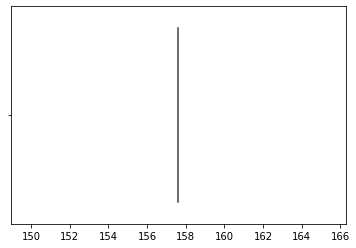

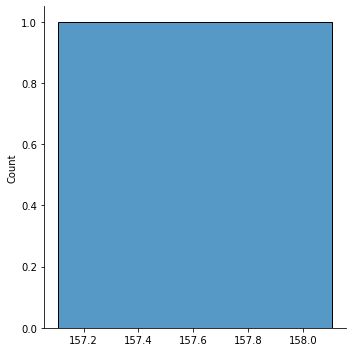

In [142]:
t_idx = test_inter.transect_id.unique().tolist()
std = []
for t in t_idx[2:]:
    inter = test_inter[test_inter.transect_id == t]
    inter_std =  np.std(inter.dist_to_transect_origin)
    inter_zs = stats.zscore(inter.dist_to_transect_origin)
    print(inter_zs)
    std.append(inter_std)
    break
import seaborn as sns
sns.violinplot(x=std)
sns.displot(std)

                                               geometry       length
0     LINESTRING (11771187.819 1028277.248, 11773093...  2137.164531
1     LINESTRING (11771037.457 1028611.538, 11773125...  2169.020500
2     LINESTRING (11770994.233 1029237.372, 11773509...  2514.850785
3     LINESTRING (11772768.258 1029386.134, 11773478...   733.098682
4     LINESTRING (11772952.416 1029394.625, 11773440...   539.298008
...                                                 ...          ...
4920  LINESTRING (11667963.891 1029272.118, 11667759...   207.306674
4921  LINESTRING (11668009.558 1029320.218, 11667795...   217.241176
4922  LINESTRING (11668044.272 1029369.959, 11667829...   218.451808
4923  LINESTRING (11668021.523 1029428.024, 11667807...   217.201211
4924  LINESTRING (11668009.698 1029478.650, 11667843...   167.934605

[4925 rows x 2 columns]
4925


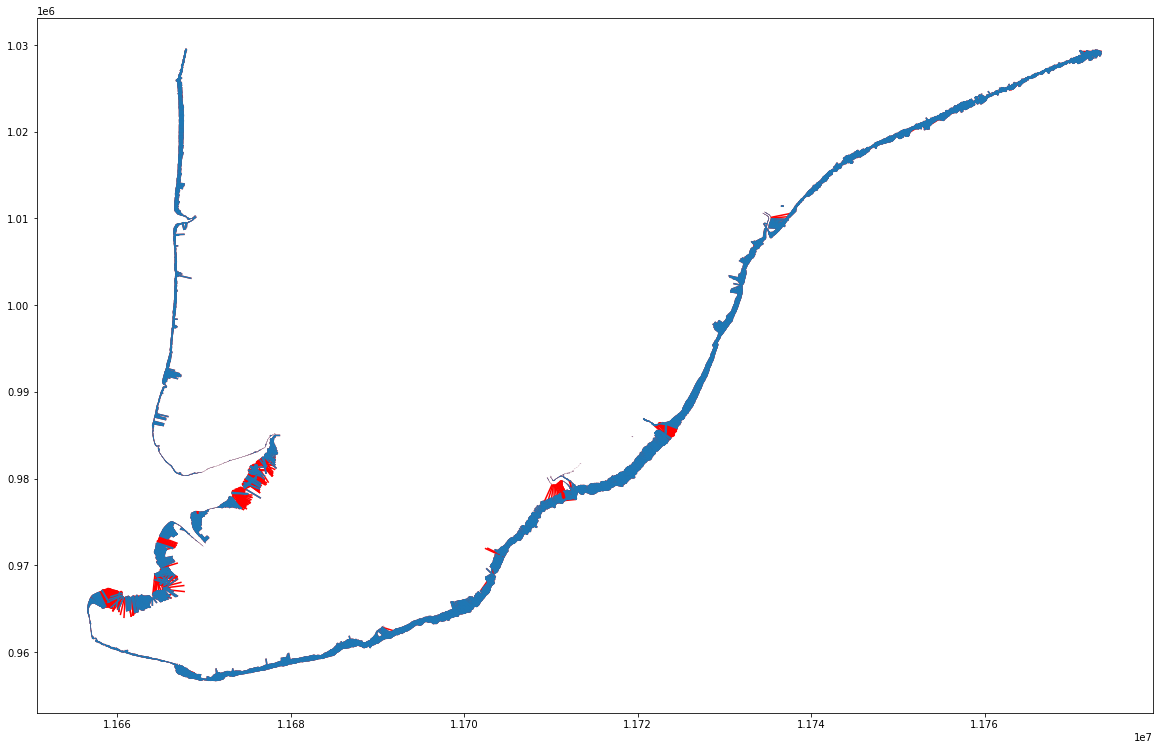

In [15]:
test_inter = p1_inter
t_idx = test_inter.transect_id.unique().tolist()
std = []
lines = []
for t in t_idx[1:]:
    inter = test_inter[test_inter.transect_id == t]
    inter_median = np.median(inter.dist_to_transect_origin)
    inter_std =  np.std(inter.dist_to_transect_origin)
    std.append(inter_std)lines_cleaned.to_file(os.path.join(os.getcwd(),"test_data","P1_inter_transects_cleaned"),driver="GeoJSON")
lines_gdf.to_file(os.path.join(os.getcwd(),"test_data","P1_inter_transects"),driver="GeoJSON")
    inter = inter[inter.dist_to_transect_origin.map(lambda x: abs(x-inter_median))<abs(4*inter_std)]
    tmin = np.min(inter.dist_to_transect_origin)
    tmax = np.max(inter.dist_to_transect_origin)
    if len(inter)>0:
        p1 = inter[inter.dist_to_transect_origin == tmin].geometry.iloc[0]
        p2 = inter[inter.dist_to_transect_origin == tmax].geometry.iloc[0]
        line = shp.geometry.LineString([p1,p2])
        lines.append(line)
lines_gdf = gpd.GeoDataFrame(geometry=lines,crs=crs)


lines_gdf['length'] = [line.geometry.length for i, line in lines_gdf.iterrows()]    
print(lines_gdf)
lines_gdf['z_score']=stats.zscore(lines_gdf['length'])
lines_cleaned = lines_gdf.loc[lines_gdf['z_score'].abs()<=2]
print(len(lines_gdf))


fig,ax = plt.subplots(figsize=(20,30))
#test_transects.plot(ax=ax,color="green")
lines_gdf.plot(ax=ax,color="red")
lines_cleaned.plot(ax=ax)

lines_cleaned.to_file(os.path.join(os.getcwd(),"test_data","P1_inter_transects_cleaned"),driver="GeoJSON")
lines_gdf.to_file(os.path.join(os.getcwd(),"test_data","P1_inter_transects"),driver="GeoJSON")
#test_inter.plot(ax=ax,color="red",markersize=10)

In [102]:
gpd.GeoDataFrame.plot?

Signature: gpd.GeoDataFrame.plot(self, *args, **kwargs)
Docstring:
Plot a GeoDataFrame.

Generate a plot of a GeoDataFrame with matplotlib.  If a
column is specified, the plot coloring will be based on values
in that column.

Parameters
----------
df : GeoDataFrame
    The GeoDataFrame to be plotted.  Currently Polygon,
    MultiPolygon, LineString, MultiLineString and Point
    geometries can be plotted.
column : str, np.array, pd.Series (default None)
    The name of the dataframe column, np.array, or pd.Series to be plotted.
    If np.array or pd.Series are used then it must have same length as
    dataframe. Values are used to color the plot. Ignored if `color` is
    also set.
cmap : str (default None)
    The name of a colormap recognized by matplotlib.
color : str (default None)
    If specified, all objects will be colored uniformly.
ax : matplotlib.pyplot.Artist (default None)
    axes on which to draw the plot
cax : matplotlib.pyplot Artist (default None)
    axes on which to